In [44]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [2]:
def get_dataset(path):
    data_csv = pd.read_csv(path)

    df_0 = data_csv[(data_csv['disease'] != "DENGUE,CHIKUNGUNYA") & (data_csv['disease'] != "ARBOVIROSIS")]
    # Update the 'i_cases' column in the DataFrame 'df_0' where the value is 0 with a random exponential value between 1e-9 and 1.
    df_0.loc[df_0['i_cases'] == 0, 'i_cases'] = np.exp(np.random.uniform(np.log(1e-9), np.log(1)))

    # Group by specified columns and apply mutations
    df_0 = df_0.groupby(
        ['name', 'level', 'disease', 'classification'],
        group_keys=False
    ).apply(lambda group: (
        group.assign(id_proy=group['name'] + '-' + group['disease'] + '-' + group['classification'],
                     i_cases=group['i_cases'] + np.exp(np.random.uniform(np.log(1e-9), np.log(1), size=len(group))),
                     csum=group['i_cases'].cumsum())
    )
            ).reset_index(drop=True)
    # create columns of time
    df_0['date'] = pd.to_datetime(df_0['date'])
    df_0['t'] = (df_0['date'] - df_0['date'].min() + (1 * np.timedelta64(1, 'D'))) / np.timedelta64(1, 'D')
    return df_0

In [3]:
dataset = get_dataset('../data/case_data_full.csv')

/var/folders/bx/bkqd8jm57437t30_zs7693sm0000gn/T/ipykernel_80111/2159071459.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.033144106494744946' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_0.loc[df_0['i_cases'] == 0, 'i_cases'] = np.exp(np.random.uniform(np.log(1e-9), np.log(1)))
/var/folders/bx/bkqd8jm57437t30_zs7693sm0000gn/T/ipykernel_80111/2159071459.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda group: (


In [39]:
# Agrupación base para lags y prediction
group_keys = ['id_proy', 'level', 'name', 'disease', 'classification']

# Variable objetivo futura (shift agrupado)
dataset['prediction'] = dataset.groupby(group_keys)['i_cases'].shift(-4)
dataset = dataset.dropna(subset=['prediction']).reset_index(drop=True)

train = dataset[dataset['id_proy'] != "CENTRAL-DENGUE-CONFIRMADO"]
test = dataset[dataset['id_proy'] == "CENTRAL-DENGUE-CONFIRMADO"]

In [40]:
print(dataset.columns)

Index(['date', 'name', 'level', 'disease', 'classification', 'i_cases',
       'Population', 'incidence', 'temp_promedio_7d', 'precip_promedio_7d',
       'temp_promedio_14d', 'precip_promedio_14d', 'id_proy', 'csum', 't',
       'prediction'],
      dtype='object')


Epoch 1/200
643/643 - 1s - 1ms/step - loss: 3.4370e-04 - mae: 0.0058 - val_loss: 8.2991e-05 - val_mae: 0.0080
Epoch 2/200
643/643 - 0s - 548us/step - loss: 2.5053e-04 - mae: 0.0049 - val_loss: 2.5961e-05 - val_mae: 0.0042
Epoch 3/200
643/643 - 0s - 614us/step - loss: 2.1257e-04 - mae: 0.0046 - val_loss: 9.0114e-06 - val_mae: 0.0025
Epoch 4/200
643/643 - 0s - 530us/step - loss: 2.0222e-04 - mae: 0.0046 - val_loss: 3.4557e-06 - val_mae: 0.0015
Epoch 5/200
643/643 - 0s - 525us/step - loss: 1.9111e-04 - mae: 0.0045 - val_loss: 5.0132e-06 - val_mae: 0.0018
Epoch 6/200
643/643 - 0s - 526us/step - loss: 1.7860e-04 - mae: 0.0041 - val_loss: 3.5367e-05 - val_mae: 0.0051
Epoch 7/200
643/643 - 0s - 528us/step - loss: 1.7941e-04 - mae: 0.0041 - val_loss: 1.8418e-05 - val_mae: 0.0039
Epoch 8/200
643/643 - 0s - 619us/step - loss: 1.6736e-04 - mae: 0.0039 - val_loss: 1.6404e-05 - val_mae: 0.0038
Epoch 9/200
643/643 - 0s - 537us/step - loss: 1.6908e-04 - mae: 0.0039 - val_loss: 5.9557e-05 - val_mae: 0

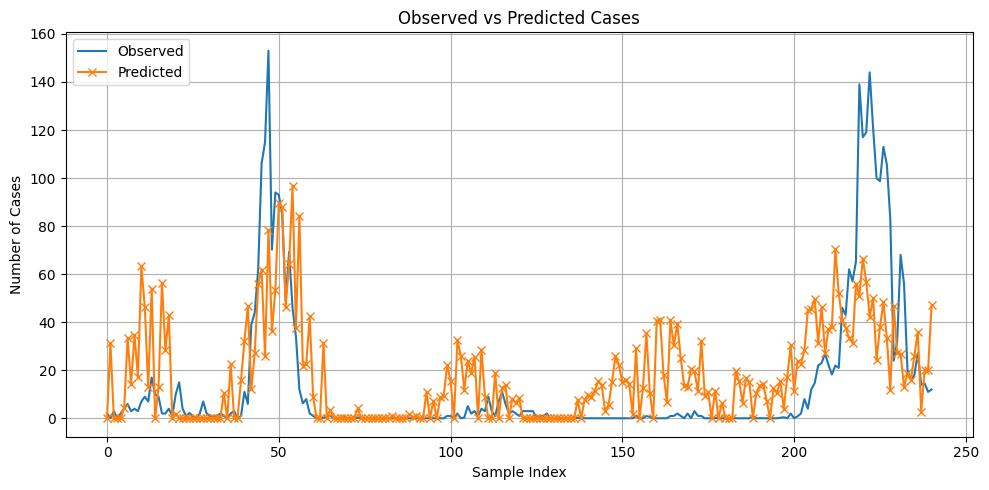

In [53]:
feature_names = ['t', 'i_cases','csum','incidence','temp_promedio_7d','precip_promedio_7d']

x_train, x_test, y_train, y_test = train[feature_names].values, test[feature_names].values, train[
    'prediction'].values, test['prediction'].values

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

model = keras.models.Sequential([
    keras.layers.Input(shape=(x_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(
    x_train_scaled, y_train_scaled,
    validation_data=(x_test_scaled, y_test_scaled),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)

pred_scaled = model.predict(x_test_scaled).flatten()
predictions = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
predictions = np.maximum(predictions, 0)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Observed')
plt.plot(predictions, label='Predicted', marker='x')
plt.title('Observed vs Predicted Cases')
plt.xlabel('Sample Index')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()